In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook

In [3]:
#Set up environemnt
import sys
#Append PLATUS libraries if these are not set in your PYTHONPATH 
#sys.path.append('/home/jl12e12/PLATUS/')
#sys.path.append('/home/jl12e12/PLATUS/fortran/lib/')
import lib_hipstar as lh
import tools
import lines as l
import numpy as np
import matplotlib.pyplot as plt
from matplotlib2tikz import save as tikz_save
tikz=True
pdf=True
import os

import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc

from mpl_toolkits.mplot3d import axes3d

In [4]:
import lib_subspaces as lsub
from matplotlib.backends.backend_pdf import PdfPages

In [5]:
cd ~/HPT_500k/HPT_LS05_DOM30_TI5/Subspaces/

/mnt/drive2/re_500k/HPT_LS05_DOM30_TI5/Subspaces


In [6]:
%%time
blocks=[1]
n_bl=len(blocks)
start_TS=5400601
stop_TS= 5410101
inc_TS=500
steps=range(start_TS,stop_TS,inc_TS)
turned_1=lsub.subspace('TURNED',21,start_TS,blocks,source_folder='./')
turned_1.load_grid()
turned_1.load_data(steps,read_all=True)

The dataset requires 587.516785 Mb of RAM
CPU times: user 10 s, sys: 13 s, total: 23.1 s
Wall time: 24.9 s


In [7]:
tau_w=lsub.subspace('WALL_SH_HEAT',20,start_TS,blocks,source_folder='./')
tau_w.load_grid()
tau_w.load_data(steps,read_all=True,limits=[[0,0,0,0,0,0]])
print tau_w.data[0].shape

The dataset requires 25.067383 Mb of RAM
(4, 19, 1, 224, 386)


In [8]:
print tau_w.header[0][0]

[1, 224, 386]


<IPython.core.display.Javascript object>


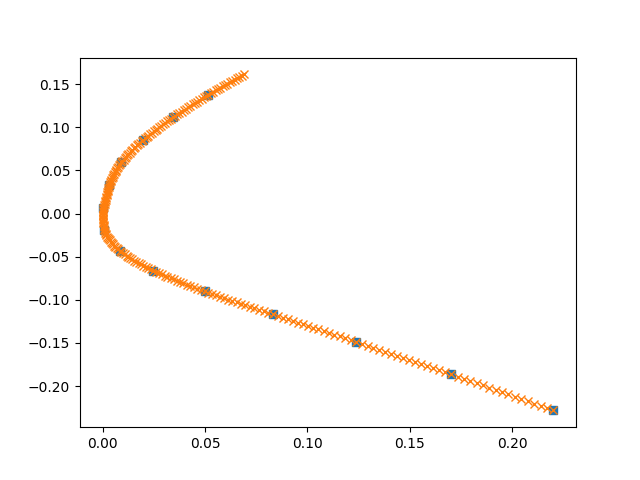

In [9]:
plt.figure()
for ib in range(n_bl):
    plt.plot(turned_1.grid[ib][0,-1,:,0],turned_1.grid[ib][1,-1,:,0],'s')
    plt.plot(tau_w.grid[ib][0,0,:,0],tau_w.grid[ib][1,0,:,0],'x')    

# Get mean Flow Field

In [10]:
turned_mean=[]
for ib in range(n_bl):
    nx,ny,nz=turned_1.header[0][ib]
    turned_mean.append(np.zeros([nx,ny,3]))
    for i,j in enumerate([[2,4],[3,5]]):
        turned_mean[ib][:,:,i]=turned_1.data[ib][j[0],0,:,:,0]-turned_1.data[ib][j[1],0,:,:,0]
    for k in range(nz):
        for nit in range(len(steps)):
            turned_mean[ib][:,:,2]+=turned_1.data[ib][11,0,:,:,k]
    turned_mean[ib][:,:,2]/=float(nz*len(steps))

<IPython.core.display.Javascript object>


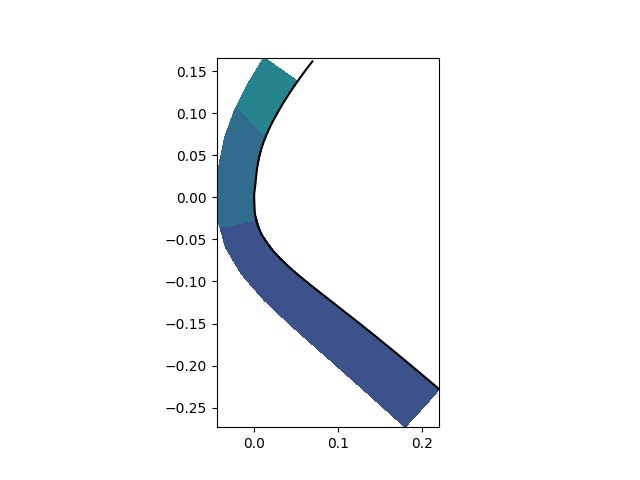

In [11]:
plt.figure()
plt.axes(aspect=1.)
for ib in range(n_bl):
    plt.plot(tau_w.grid[ib][0,0,:,0],tau_w.grid[ib][1,0,:,0],'k')
    plt.contourf(turned_1.grid[ib][0,:,:,0],turned_1.grid[ib][1,:,:,0],turned_mean[ib][:,:,0],levels=np.linspace(-3,7.,11))

<IPython.core.display.Javascript object>


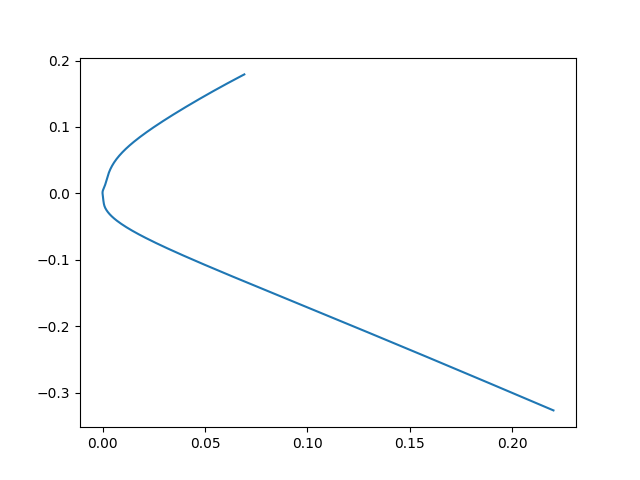

Leading edge index 124


In [12]:
plt.figure()
dist=[]
dist_red=[]
for ib in range(n_bl):
    nx,ny,nz=tau_w.header[0][ib]
    dist.append(np.empty(ny))
    dist_red.append(np.empty(ny/16))
    if ib==0:
        dist[ib][0]=0.
    else:
        dist[ib][0]=dist[ib-1][-1]
    for j in range(1,ny):
        dist[ib][j]=dist[ib][j-1]+np.sqrt((tau_w.grid[ib][0,0,j,0]-tau_w.grid[ib][0,0,j-1,0])**2
                                         +(tau_w.grid[ib][1,0,j,0]-tau_w.grid[ib][1,0,j-1,0])**2)
    if ib==0:
        temp1=100.
        for j in range(ny):
            if tau_w.grid[ib][0,0,j,0]<temp1:
                i_min=j
                temp1=tau_w.grid[ib][0,0,j,0]
        temp1=dist[ib][i_min]
        dist[ib][:]-=temp1
    dist_red[ib][:]=dist[ib][0:-1:16]
    plt.plot(tau_w.grid[ib][0,0,:,0],dist[ib])
print 'Leading edge index %i'%i_min    

In [13]:
# fig=plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.set_aspect(1.)
# ax.view_init(azim=-45, elev=30)
# for ib in range(n_bl):
#     nx,ny,nz=tau_w.header[0][ib]      
#     ax.plot_surface(tau_w.grid[ib][0,0,:,:],tau_w.grid[ib][2,0,:,:],tau_w.grid[ib][1,0,:,:],color='b'
#                 ,rstride=10, cstride=10, alpha=0.3)   
#     ax.set_xlim([-0.1,1.1])
#     ax.set_ylim([-1.1,0.5])    
#     nx,ny,nz=turned_1.header[0][ib]  
#     for j in range(0,ny):
#         ax.plot_surface(turned_1.grid[ib][0,:,j,:],turned_1.grid[ib][2,:,j,:],turned_1.grid[ib][1,:,j,:],color='k'
#                 ,rstride=10, cstride=10, alpha=0.3)
#         ax.plot_surface(turned_1.grid[ib][0,:,j,:],turned_1.grid[ib][2,:,j,:],turned_1.grid[ib][1,:,j,:],color='k'
#                 ,rstride=10, cstride=10, alpha=0.3)
#     extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
#     sz = extents[:,1] - extents[:,0]
#     centers = np.mean(extents, axis=1)
#     maxsize = max(abs(sz))
#     r = maxsize/2
#     for ctr, dim in zip(centers, 'xyz'):
#         getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
#     plt.savefig('planes_considered.pdf')

<IPython.core.display.Javascript object>


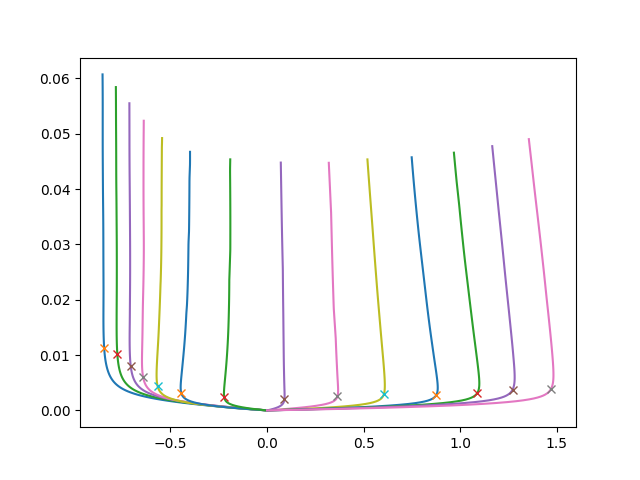

In [14]:
j=8
ib=0
bl_ind=[]
u_t_max=[]
for ib in range(n_bl):
    nx,ny,nz=turned_1.header[0][ib]
    temp=[]
    temp_u=[]
    plt.figure()
    for j in range(ny):
        temp1=np.argmax(np.abs(turned_mean[ib][:,j,0]))
        for i in range(nx):
            if abs(turned_mean[ib][nx-i-1,j,0])>0.99*abs(turned_mean[ib][temp1,j,0]):
                temp.append(nx-i-1)
                temp_u.append(turned_mean[ib][nx-i-1,j,0])
                break
        plt.plot(turned_mean[ib][:,j,0],turned_1.data[ib][1,0,:,j,0])
        plt.plot(turned_mean[ib][temp[-1],j,0],turned_1.data[ib][1,0,temp[-1],j,0],'x')   
    bl_ind.append(temp)
    u_t_max.append(temp_u)

<IPython.core.display.Javascript object>


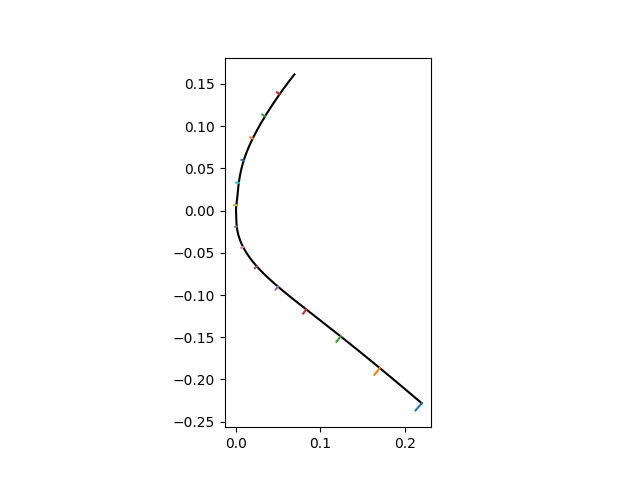

In [15]:
plt.figure()
plt.axes(aspect=1.)
for ib in range(n_bl):
    nx,ny,nz=turned_1.header[0][ib]
    plt.plot(tau_w.grid[ib][0,0,:,0],tau_w.grid[ib][1,0,:,0],'k')
    for j in range(ny):
        plt.plot(turned_1.grid[ib][0,bl_ind[ib][j]:,j,0],turned_1.grid[ib][1,bl_ind[ib][j]:,j,0])        

In [16]:
#mean tau_w
tau_mean=[]
for ib in range(n_bl):
    nx,ny,nz=tau_w.header[0][ib]    
    tau_mean.append(np.zeros([ny,4]))
    for k in range(nz):
        for j in range(ny):
            i=0
            for nit in range(len(steps)):
                tau_mean[-1][j,0]+=tau_w.data[ib][0,nit,0,j,k]
                tau_mean[-1][j,1]+=tau_w.data[ib][1,nit,0,j,k]
    for j in range(ny):
            tau_mean[-1][j,0:2]/=float(nz*len(steps))
    for k in range(nz):
        for j in range(ny):
            i=0
            for nit in range(len(steps)):
                tau_mean[-1][j,2]+=(tau_w.data[ib][0,nit,0,j,k]-tau_mean[-1][j,0])**2
                tau_mean[-1][j,3]+=(tau_w.data[ib][1,nit,0,j,k]-tau_mean[-1][j,1])**2

    tau_mean[-1][:,2:]/=float(nz*len(steps))   
    tau_mean[-1][:,2:]=np.sqrt(tau_mean[-1][:,2:])

<IPython.core.display.Javascript object>


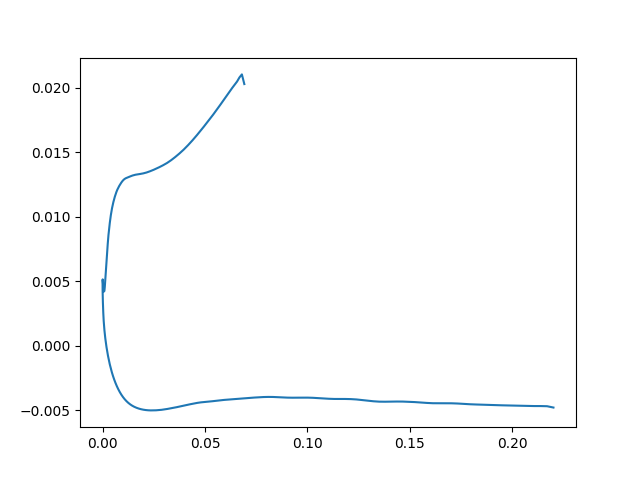

<IPython.core.display.Javascript object>


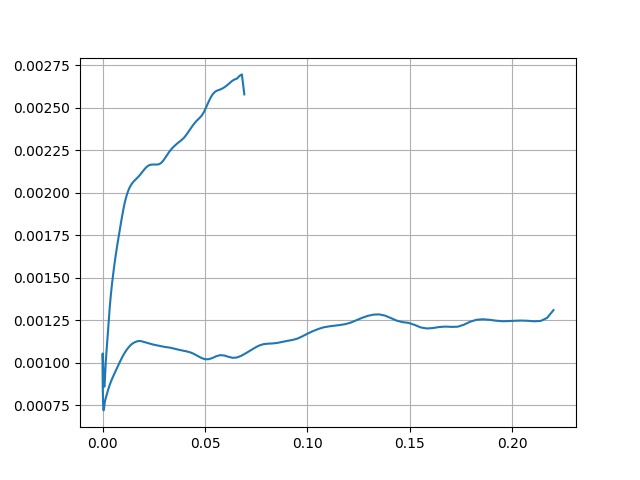

In [17]:
plt.figure()
for ib in range(n_bl):
    plt.plot(tau_w.grid[ib][0,0,:,0],-tau_mean[ib][:,0])
plt.figure()
for ib in range(n_bl):    
    plt.plot(tau_w.grid[ib][0,0,:,0],tau_mean[ib][:,2])        
plt.grid()

# Correlations

In [18]:
nx,ny,nz=tau_w.header[0][ib]
ib=0
corr_tau_qn=[]
corr_tau_qn.append(np.zeros([ny]))
for k in range(nz):
    for j in range(ny):
        for nit in range(len(steps)):
            corr_tau_qn[-1][j]+=((tau_w.data[ib][0,nit,0,j,k]-tau_mean[ib][j,0])*
                              (tau_w.data[ib][1,nit,0,j,k]-tau_mean[ib][j,1]))
corr_tau_qn[-1][:]/=float(nz*len(steps))
corr_tau_qn[-1][:]/=(tau_mean[ib][:,2]*tau_mean[ib][:,3])

<IPython.core.display.Javascript object>


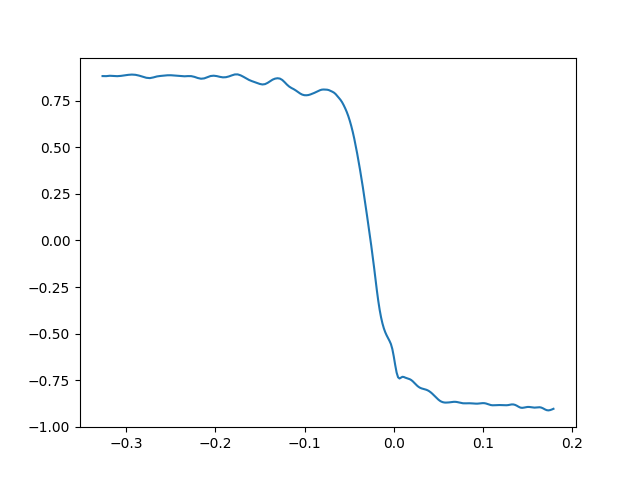

In [19]:
plt.figure()
plt.plot(dist[ib],corr_tau_qn[ib])

In [20]:
ib=0
nx,ny,nz=turned_1.header[0][ib]
corr_tau_field=[]
corr_tau_field.append(np.zeros([3,ny,nx]))
for k in range(nz):
    for j in range(ny):
        j_tau=j*16        
        for nit in range(len(steps)):
                corr_tau_field[ib][0,j,:]+=((tau_w.data[ib][0,nit,0,j_tau,k]-tau_mean[ib][j_tau,0])
                                        *turned_1.data[ib][4,nit,:,j,k])
                corr_tau_field[ib][1,j,:]+=((tau_w.data[ib][0,nit,0,j_tau,k]-tau_mean[ib][j_tau,0])
                                       *(turned_1.data[ib][11,nit,:,j,k])-turned_mean[ib][i,j,2])
corr_tau_field[ib][:,:,:]/=float(nz*len(steps))


<IPython.core.display.Javascript object>


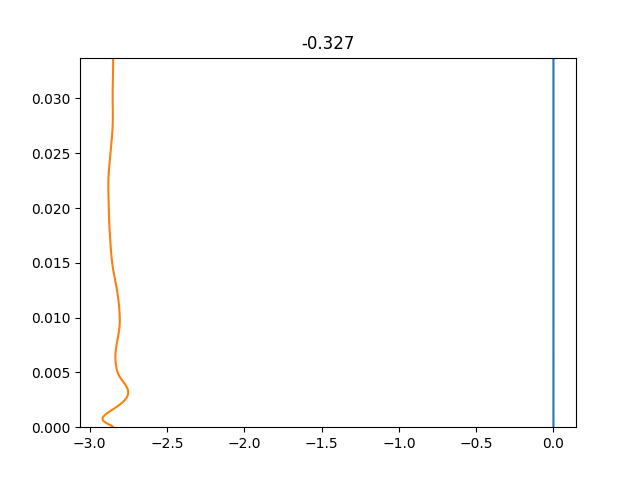

<IPython.core.display.Javascript object>


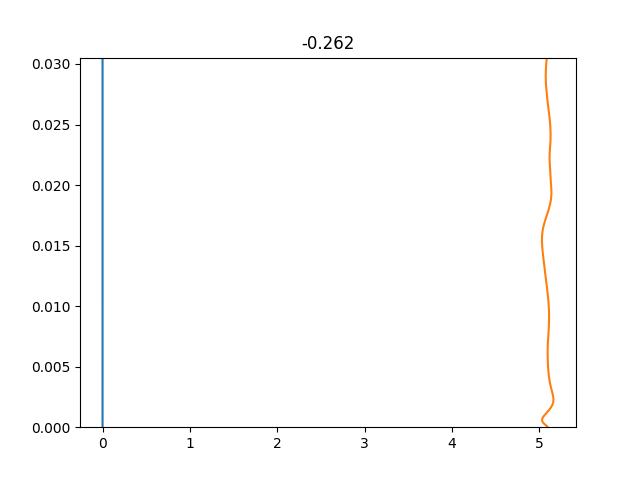

<IPython.core.display.Javascript object>


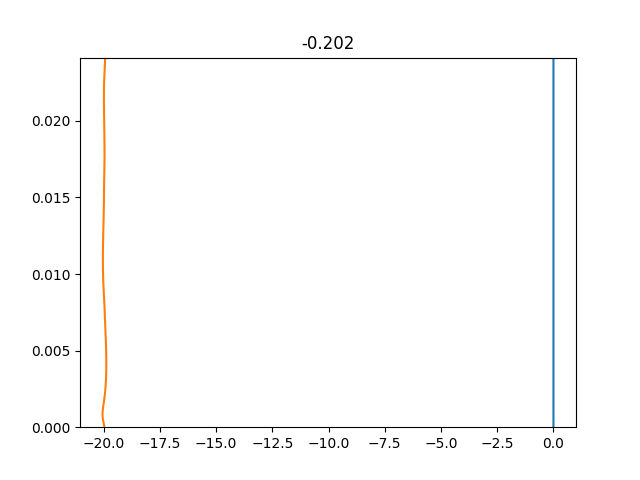

<IPython.core.display.Javascript object>


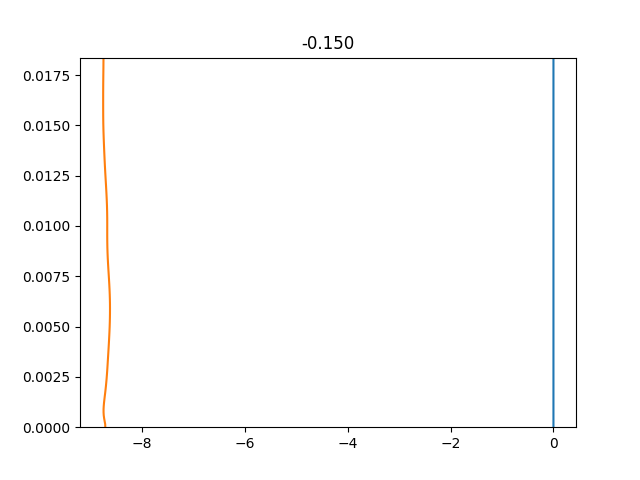

<IPython.core.display.Javascript object>


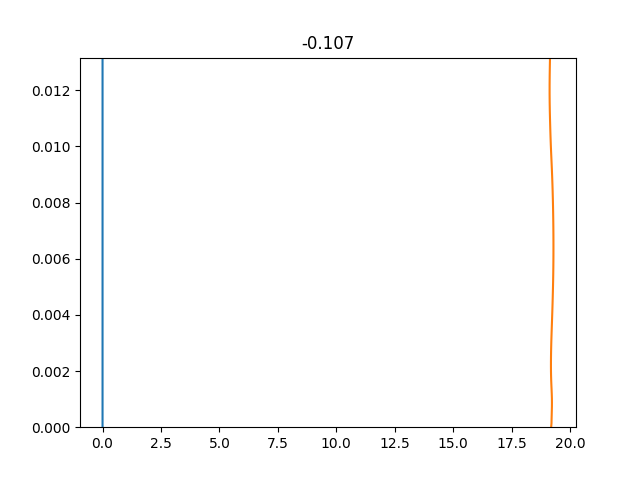

<IPython.core.display.Javascript object>


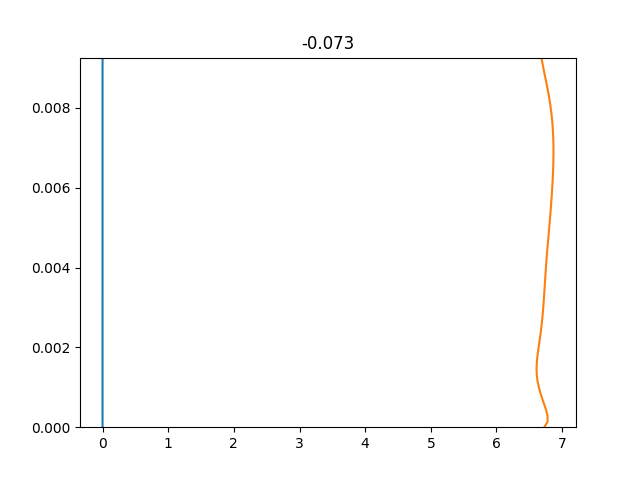

<IPython.core.display.Javascript object>


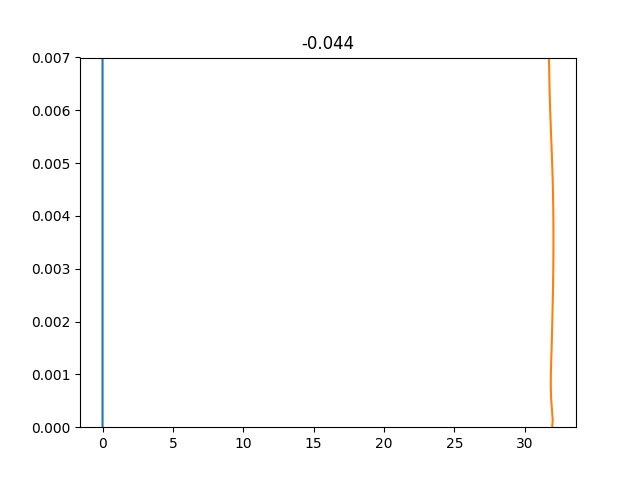

<IPython.core.display.Javascript object>


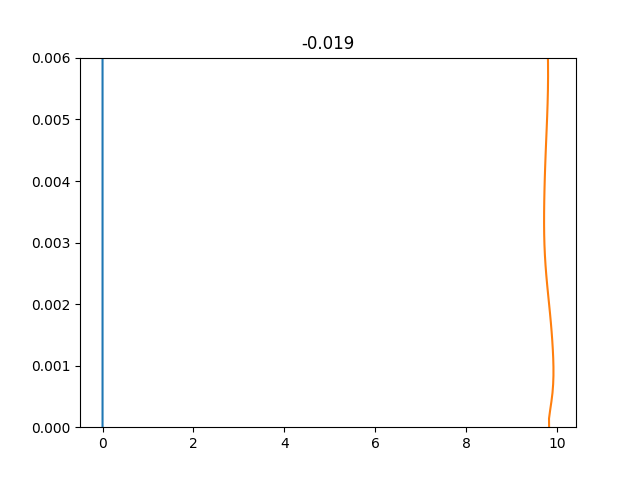

<IPython.core.display.Javascript object>


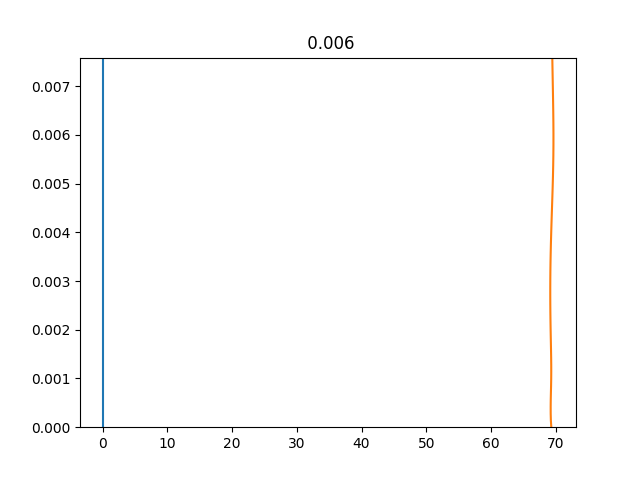

<IPython.core.display.Javascript object>


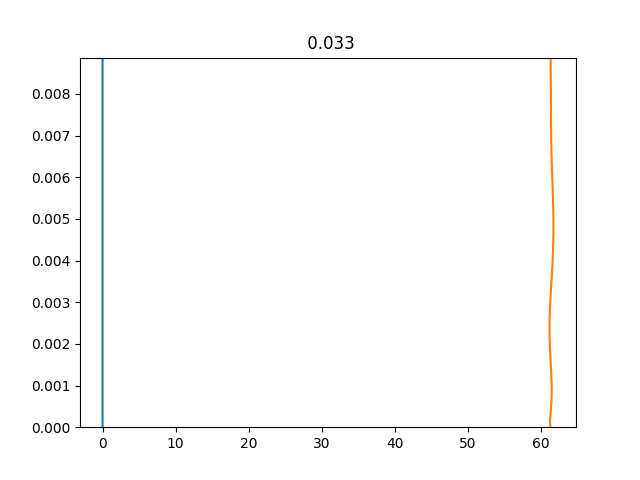

<IPython.core.display.Javascript object>


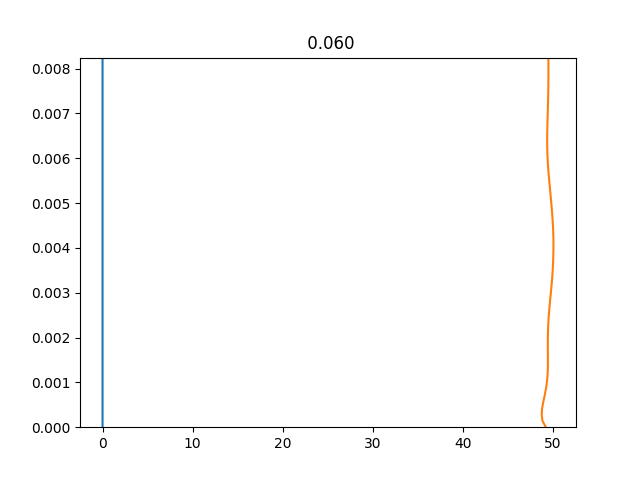

<IPython.core.display.Javascript object>


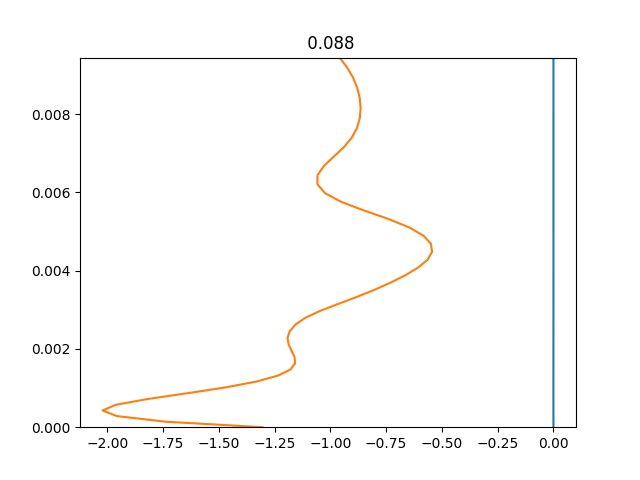

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


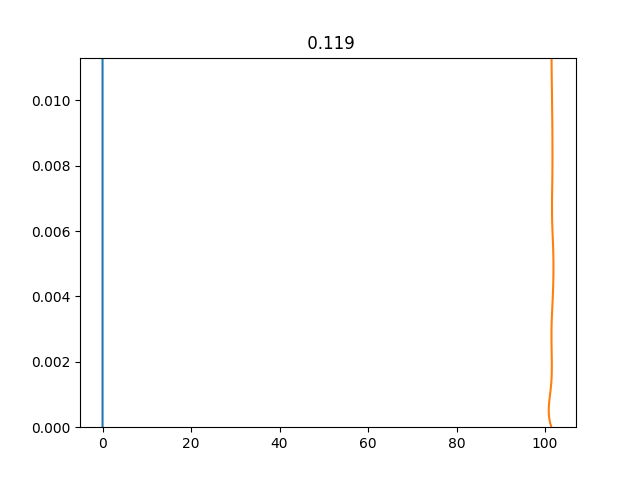

In [21]:
ib=0
j=11
for j in range(13):
    plt.figure()
    plt.plot(corr_tau_field[ib][0,j,:],turned_1.data[ib][1,0,:,j,0])
    plt.plot(corr_tau_field[ib][1,j,:],turned_1.data[ib][1,0,:,j,0])
    plt.ylim(0,3.*turned_1.data[ib][1,0,bl_ind[ib][j],j,0])
    plt.title('%6.3f'%dist_red[ib][j])
    plt.savefig('corr_tau_q_%i.pdf'%j)
